In [1]:
import os

# The powerful libraries from rdkit I will use:
from rdkit import Chem
from rdkit.Chem import rdFMCS,AllChem, Draw, PandasTools
from rdkit.Chem.Draw import DrawingOptions

import py3Dmol

import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import sys, os, random
sys.path.insert(1, 'utilities/')
from utils import get_inplace_rmsd

%matplotlib inline

## Molecular Docking

In [2]:
os.chdir('test/Molecular_Docking/')

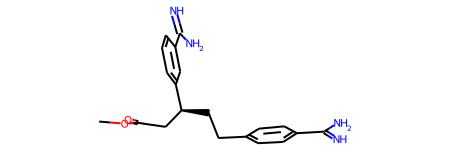

In [3]:
Reference=Chem.MolFromMol2File('1AZ8_lig_H.mol2')
Reference.SetProp('_Name','Ref')
Reference

,Pose,Score,ID,ROMol
0,1,-7.538,1AZ8_lig_vina_out.pdbqt,
1,2,-7.114,1AZ8_lig_vina_out.pdbqt,

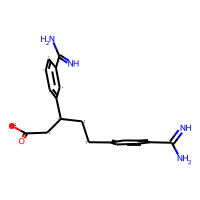
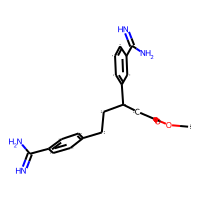

In [4]:
VinaPoses=PandasTools.LoadSDF('1AZ8_lig_vina_out.sdf')
VinaPoses.head(2)

,Pose,Score,ID,ROMol,RMSD,Software
0,1,-7.538,A_1,,1.375844,AutodockVina
1,2,-7.114,A_2,,8.076298,AutodockVina

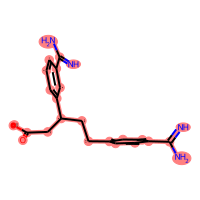
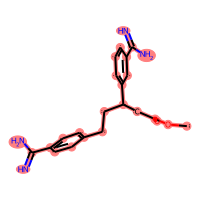

In [5]:
VinaPoses['ID']=["A_"+VinaPoses.loc[i,'Pose'] for i in VinaPoses.index]
VinaPoses['RMSD']=[get_inplace_rmsd(ref=Reference,target=VinaPoses.loc[i,"ROMol"]) for i in VinaPoses.index]
VinaPoses['Software']=["AutodockVina" for i in VinaPoses.index]

VinaPoses.head(2)

,minimizedAffinity,ID,ROMol
0,-8.06023,1AZ8,
1,-8.02622,1AZ8,

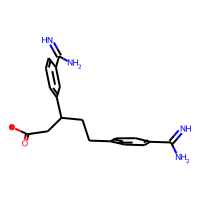
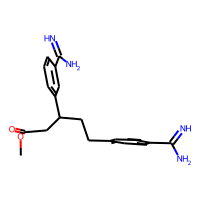

In [6]:
SminaPoses=PandasTools.LoadSDF('1AZ8_lig_smina_out.sdf')
SminaPoses.head(2)

,Score,ID,ROMol,Pose,RMSD,Software
0,-8.06023,S_1,,1,0.847081,Smina
1,-8.02622,S_2,,2,1.576420,Smina

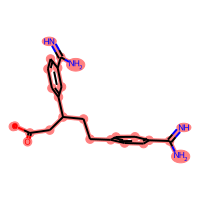
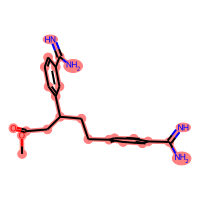

In [7]:
SminaPoses['Pose']=[str(i+1) for i in SminaPoses.index]
SminaPoses['ID']=["S_"+SminaPoses.loc[i,'Pose'] for i in SminaPoses.index]
SminaPoses.rename({'minimizedAffinity': 'Score'}, axis='columns',inplace=True)
SminaPoses['RMSD']=[get_inplace_rmsd(ref=Reference,target=SminaPoses.loc[i,"ROMol"]) for i in SminaPoses.index]
SminaPoses['Software']=["Smina" for i in SminaPoses.index]

SminaPoses.head(2)

,Pose,Score,ID,ROMol
0,1,-8.92,,
1,1,-8.84,,

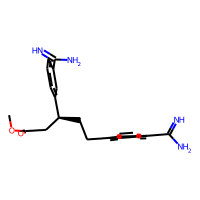
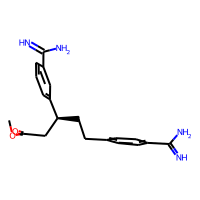

In [8]:
LedockPoses=PandasTools.LoadSDF('1AZ8_lig_ledock_out.sdf')
LedockPoses.head(2)

,Pose,Score,ID,ROMol,RMSD,Software
0,1,-8.92,L_1,,1.239586,LeDock
1,2,-8.84,L_2,,1.233989,LeDock

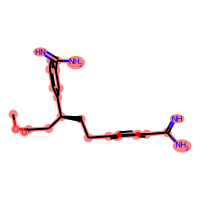
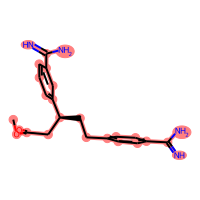

In [9]:
LedockPoses['Pose']=[str(i+1) for i in LedockPoses.index]
LedockPoses['ID']=["L_"+LedockPoses.loc[i,'Pose'] for i in LedockPoses.index]
LedockPoses['RMSD']=[get_inplace_rmsd(ref=Reference,target=LedockPoses.loc[i,"ROMol"]) for i in LedockPoses.index]
LedockPoses['Software']=["LeDock" for i in LedockPoses.index]

LedockPoses.head(2)

,Pose,Score,ID,ROMol,RMSD,Software
0,4,-8.18000,L_4,,0.815394,LeDock
1,1,-8.06023,S_1,,0.847081,Smina
2,2,-8.84000,L_2,,1.233989,LeDock
3,1,-8.92000,L_1,,1.239586,LeDock
4,6,-8.05000,L_6,,1.346993,LeDock

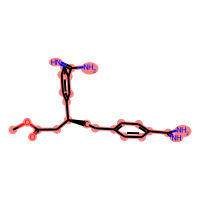
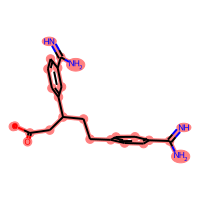
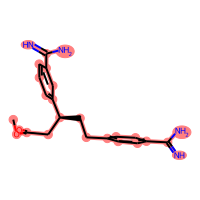
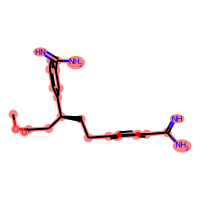
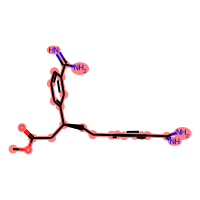

In [13]:
AllPoses=pd.concat([VinaPoses,SminaPoses,LedockPoses])
AllPoses.sort_values(by='RMSD',inplace=True)
AllPoses['Score']=[float(i) for i in AllPoses['Score']]
AllPoses.reset_index(drop=True, inplace=True)
AllPoses.head(5)

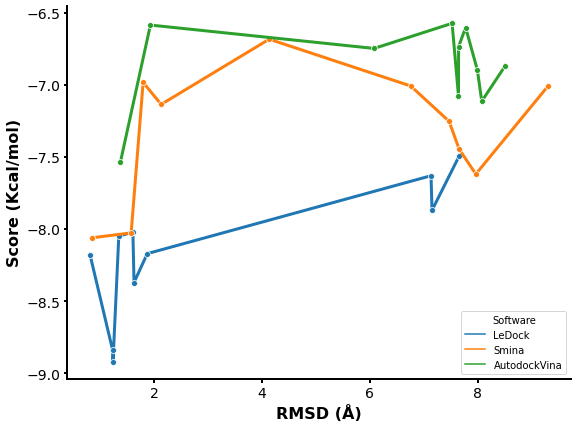

In [14]:
plt.rcParams['axes.linewidth'] = 2
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

sns.lineplot(x='RMSD',y='Score', hue='Software',data=AllPoses, lw=3, marker='o')

plt.ylabel('Score (Kcal/mol)',fontsize=16,fontweight='bold')
plt.xlabel('RMSD (Å)',fontsize=16,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.tick_params ('both',width=2,labelsize=14)

plt.show()

In [17]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('1AZ8_clean_H.pdb','r').read(),'pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.8,'color':'white'})


view.addModel(open('1AZ8_lig.mol2','r').read(),'mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

BestPose=AllPoses.loc[0,'ROMol']
p=Chem.MolToMolBlock(BestPose)
rmsd=get_inplace_rmsd(ref=Reference,target=BestPose)
print('Software: {} | Pose: {} | Score: {} | RMSD: {}'.format(AllPoses.loc[0,'Software'],AllPoses.loc[0,'Pose'],AllPoses.loc[0,'Score'],AllPoses.loc[0,'RMSD']))

view.addModel(p,'mol')
pose_m= view.getModel()
pose_m.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

view.zoomTo()
view.show()

Software: LeDock | Pose: 4 | Score: -8.18 | RMSD: 0.8153942415977495


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

,Pose,Score,ID,ROMol,RMSD,Software
0,4,-8.18,L_4,,0.815394,LeDock
1,1,-8.06023,S_1,,0.847081,Smina
2,2,-8.84,L_2,,1.233989,LeDock
3,1,-8.92,L_1,,1.239586,LeDock
4,6,-8.05,L_6,,1.346993,LeDock
5,1,-7.538,A_1,,1.375844,AutodockVina
6,2,-8.02622,S_2,,1.576420,Smina
7,7,-8.02,L_7,,1.608563,LeDock
8,3,-8.37,L_3,,1.629367,LeDock
9,9,-6.98326,S_9,,1.798259,Smina

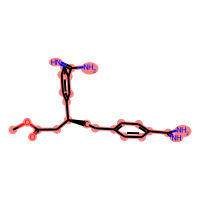
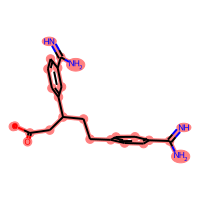
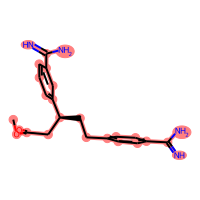
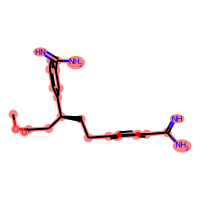
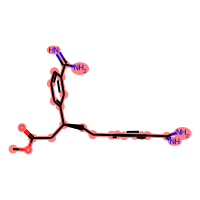
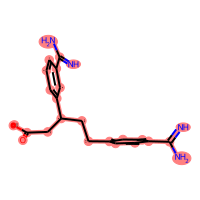
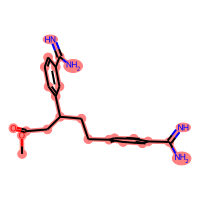
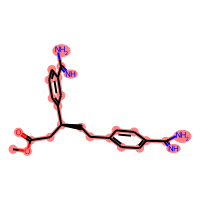
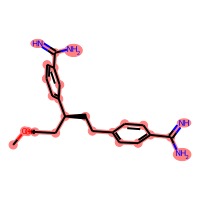
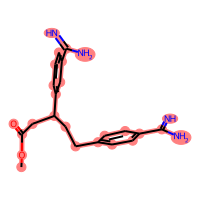
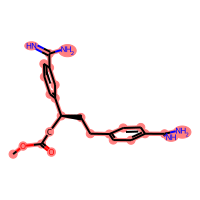
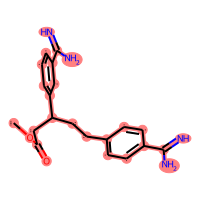
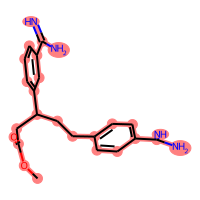
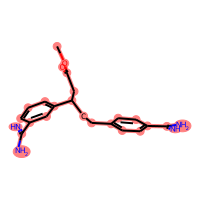
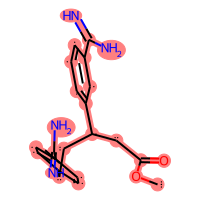
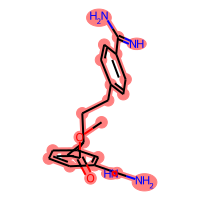
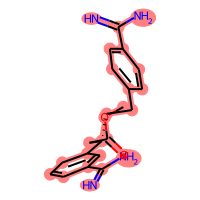
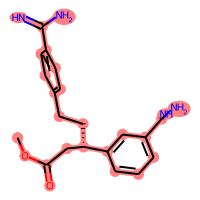
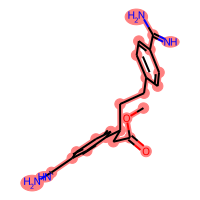
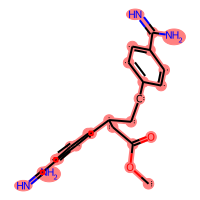
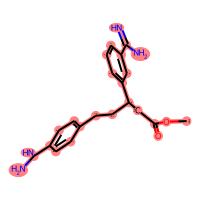
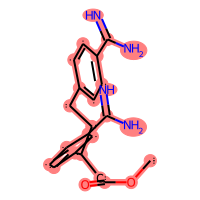
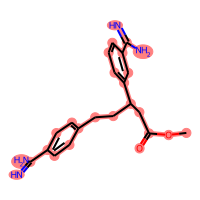
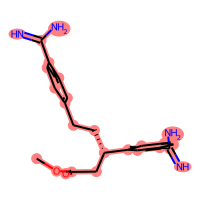
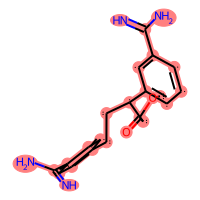
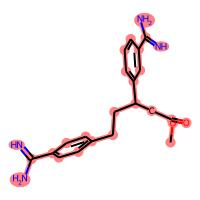
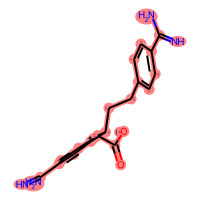
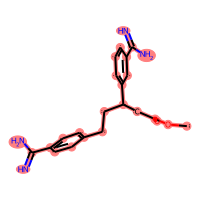
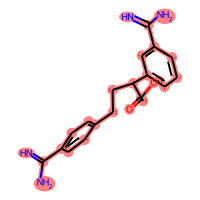
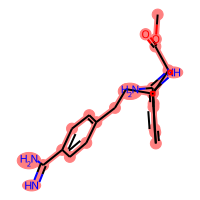
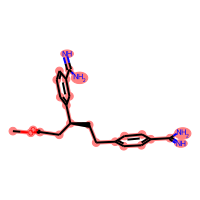

In [21]:
Ref = pd.Series({'Pose': 'NA', 'Score': 'NA', 'ID':'Reference','ROMol':Reference,'RMSD':0,'Software':'Experimental'})
AllPoses=AllPoses.append(Ref,ignore_index=True)
AllPoses

In [31]:
PandasTools.WriteSDF(AllPoses,'Analysis.sdf',properties=AllPoses.columns)

In [23]:
hmap=pd.DataFrame()
for pose_i in AllPoses.index:
    for pose_j in AllPoses.index:
        rmsd=get_inplace_rmsd(ref=AllPoses.loc[pose_i,'ROMol'],target=AllPoses.loc[pose_j,'ROMol'])
        hmap.loc[AllPoses.loc[pose_i,'ID'],AllPoses.loc[pose_j,'ID']]=rmsd

In [24]:
hmap.head(5)

,L_4,S_1,L_2,L_1,L_6,A_1,S_2,L_7,L_3,S_9,...,A_7,S_4,L_10,A_8,S_3,A_4,A_2,A_5,S_8,Reference
L_4,0.000000,0.964791,1.410453,1.294346,1.368162,1.396714,1.627437,1.647342,1.644407,1.705063,...,7.392992,7.563669,7.496887,7.541523,7.833308,7.719163,7.948092,8.358016,9.131863,0.815394
S_1,0.964791,0.000000,1.306774,1.132738,1.500427,1.140374,1.408513,1.755901,1.439298,1.601503,...,7.452169,7.505767,7.615701,7.510728,7.696729,7.901891,7.828869,8.392010,9.187336,0.847081
L_2,1.410453,1.306774,0.000000,0.940579,1.628644,1.041710,1.367127,1.430031,1.636384,2.149839,...,7.603189,7.667137,7.811119,7.789656,7.988420,8.058033,7.971682,8.578884,9.308752,1.233989
L_1,1.294346,1.132738,0.940579,0.000000,1.808218,0.825442,1.257484,1.552549,1.780376,1.986514,...,7.549214,7.739960,7.653790,7.699931,7.997303,7.937905,8.039152,8.516695,9.366391,1.239586
L_6,1.368162,1.500427,1.628644,1.808218,0.000000,1.843007,1.426617,1.160771,0.985410,1.901218,...,7.464282,7.651051,7.481255,8.020576,7.985392,8.153930,8.009831,8.796487,9.274600,1.346993


/home/angel/miniconda3/envs/Jupyter_Dock/lib/python3.8/site-packages/seaborn/matrix.py:624: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


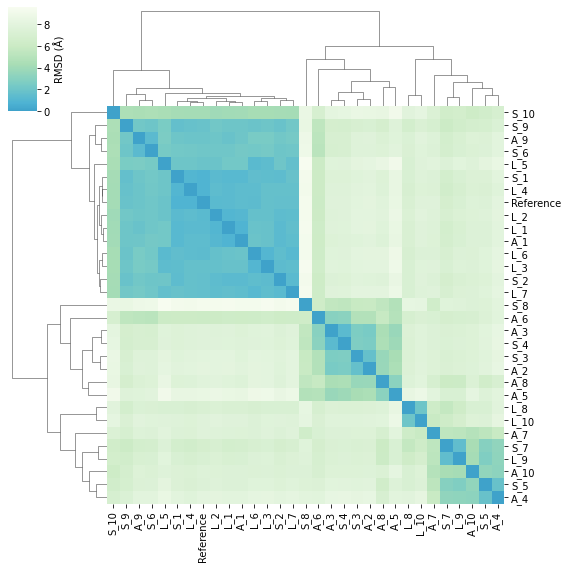

In [25]:
sns.clustermap(hmap, method='complete', metric='euclidean', xticklabels=hmap.columns, yticklabels=hmap.index, cmap="GnBu_r",figsize=(8, 8), center=2.5,
               cbar_kws=dict(label='RMSD (Å)',orientation='vertical',spacing='uniform',pad=0.02))

plt.show()

## Virtual Screening

(In construction)

In [ ]:
os.chdir('../Virtual_Screening/')

In [ ]:
SminaResults=Chem.SDMolSupplier('1X1R_lig_smina_out.sdf')

LedockResults=[]
for file in os.listdir('ledock_outfiles/'):
    if '.sdf' in file:
        LedockResults+=[mol for mol in Chem.SDMolSupplier('ledock_outfiles/'+file)]

In [ ]:
print("Smina Mols: {}".format(len(VinaResults)))

print("Ledock Mols: {}".format(len(LedockResults)))

In [ ]:
Results=pd.DataFrame()



In [ ]:
plt.rcParams['axes.linewidth'] = 2
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

sns.lineplot(x='RMSD',y='Score', hue='Software',data=table, lw=3, marker='o')

plt.ylabel('Score (Kcal/mol)',fontsize=16,fontweight='bold')
plt.xlabel('RMSD (Å)',fontsize=16,fontweight='bold')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.tick_params ('both',width=2,labelsize=14)

plt.show()

In [26]:
x=AllPoses['ROMol'][0]

In [28]:
AllPoses.

[]